<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:09:35] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


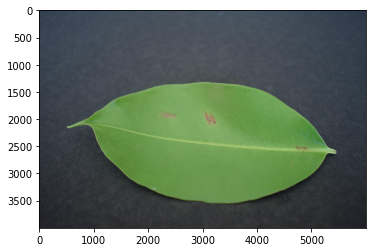

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

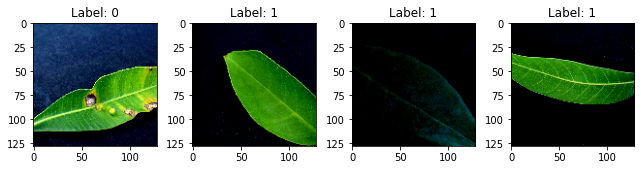

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:09:40] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:09:42] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.26216718922138 samples/sec                   batch loss = 0.5980925559997559 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2261855245900861 samples/sec                   batch loss = 0.7533590793609619 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2665563668833708 samples/sec                   batch loss = 1.3326698541641235 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2581670503663052 samples/sec                   batch loss = 0.8295003175735474 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.231678024994439 samples/sec                   batch loss = 1.1032356023788452 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2610291464828436 samples/sec                   batch loss = 1.1593379974365234 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2657380432033827 samples/sec                   batch loss = 0.5383145809173584 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2723353328289155 samples/sec                   batch loss = 0.7874162793159485 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2661012086103736 samples/sec                   batch loss = 0.7197802662849426 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2676835306628575 samples/sec                   batch loss = 1.003054141998291 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2679078052372978 samples/sec                   batch loss = 0.5963304042816162 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2693530725522368 samples/sec                   batch loss = 0.5413914918899536 | accuracy = 0.5875


Epoch[1] Batch[65] Speed: 1.2643951307132748 samples/sec                   batch loss = 0.6481912732124329 | accuracy = 0.5884615384615385


Epoch[1] Batch[70] Speed: 1.270015795320025 samples/sec                   batch loss = 0.5047075152397156 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.2707490839506919 samples/sec                   batch loss = 1.2823519706726074 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2685144433144206 samples/sec                   batch loss = 0.2971947491168976 | accuracy = 0.60625


Epoch[1] Batch[85] Speed: 1.2676150474100965 samples/sec                   batch loss = 1.7871309518814087 | accuracy = 0.6058823529411764


Epoch[1] Batch[90] Speed: 1.2692583857392785 samples/sec                   batch loss = 0.3635842204093933 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.2656041773377016 samples/sec                   batch loss = 0.7922843098640442 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2716792483750048 samples/sec                   batch loss = 0.33223631978034973 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.259393988345895 samples/sec                   batch loss = 0.36280423402786255 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.271170219980005 samples/sec                   batch loss = 1.5254319906234741 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.267528184894601 samples/sec                   batch loss = 0.5781643986701965 | accuracy = 0.6173913043478261


Epoch[1] Batch[120] Speed: 1.2667362455333153 samples/sec                   batch loss = 0.6124585866928101 | accuracy = 0.61875


Epoch[1] Batch[125] Speed: 1.2676978029297443 samples/sec                   batch loss = 0.5519749522209167 | accuracy = 0.618


Epoch[1] Batch[130] Speed: 1.267877047813849 samples/sec                   batch loss = 0.5234974026679993 | accuracy = 0.6192307692307693


Epoch[1] Batch[135] Speed: 1.267026588109059 samples/sec                   batch loss = 0.678156316280365 | accuracy = 0.6185185185185185


Epoch[1] Batch[140] Speed: 1.2603101538509616 samples/sec                   batch loss = 0.7700058817863464 | accuracy = 0.6160714285714286


Epoch[1] Batch[145] Speed: 1.260390443302843 samples/sec                   batch loss = 0.4082106947898865 | accuracy = 0.6189655172413793


Epoch[1] Batch[150] Speed: 1.2646422650712443 samples/sec                   batch loss = 0.6241798996925354 | accuracy = 0.6216666666666667


Epoch[1] Batch[155] Speed: 1.2670403671431971 samples/sec                   batch loss = 0.6176155209541321 | accuracy = 0.6241935483870967


Epoch[1] Batch[160] Speed: 1.2666575363605381 samples/sec                   batch loss = 0.49186065793037415 | accuracy = 0.61875


Epoch[1] Batch[165] Speed: 1.2689386100895392 samples/sec                   batch loss = 0.9237608909606934 | accuracy = 0.6181818181818182


Epoch[1] Batch[170] Speed: 1.26782588456487 samples/sec                   batch loss = 0.4148057997226715 | accuracy = 0.6264705882352941


Epoch[1] Batch[175] Speed: 1.2708313828364148 samples/sec                   batch loss = 0.6615539789199829 | accuracy = 0.6228571428571429


Epoch[1] Batch[180] Speed: 1.2632904508835427 samples/sec                   batch loss = 0.3062182366847992 | accuracy = 0.6208333333333333


Epoch[1] Batch[185] Speed: 1.2694055116927638 samples/sec                   batch loss = 0.34693625569343567 | accuracy = 0.6229729729729729


Epoch[1] Batch[190] Speed: 1.2778625596041289 samples/sec                   batch loss = 0.4655087888240814 | accuracy = 0.6236842105263158


Epoch[1] Batch[195] Speed: 1.2723565610306555 samples/sec                   batch loss = 1.1010364294052124 | accuracy = 0.6243589743589744


Epoch[1] Batch[200] Speed: 1.2660298390418896 samples/sec                   batch loss = 0.7067893743515015 | accuracy = 0.62875


Epoch[1] Batch[205] Speed: 1.270986287661016 samples/sec                   batch loss = 0.29445916414260864 | accuracy = 0.6292682926829268


Epoch[1] Batch[210] Speed: 1.263946285272251 samples/sec                   batch loss = 0.2481967806816101 | accuracy = 0.6297619047619047


Epoch[1] Batch[215] Speed: 1.2693257982285957 samples/sec                   batch loss = 0.6210187673568726 | accuracy = 0.6302325581395349


Epoch[1] Batch[220] Speed: 1.2638247936678348 samples/sec                   batch loss = 1.2404850721359253 | accuracy = 0.6284090909090909


Epoch[1] Batch[225] Speed: 1.2698008655151591 samples/sec                   batch loss = 0.6120206713676453 | accuracy = 0.63


Epoch[1] Batch[230] Speed: 1.2687565702889425 samples/sec                   batch loss = 0.7904266715049744 | accuracy = 0.633695652173913


Epoch[1] Batch[235] Speed: 1.2704874347025423 samples/sec                   batch loss = 0.14097321033477783 | accuracy = 0.6372340425531915


Epoch[1] Batch[240] Speed: 1.274294007143155 samples/sec                   batch loss = 0.41449013352394104 | accuracy = 0.6375


Epoch[1] Batch[245] Speed: 1.2732715904108713 samples/sec                   batch loss = 0.7358035445213318 | accuracy = 0.6377551020408163


Epoch[1] Batch[250] Speed: 1.271408737149006 samples/sec                   batch loss = 1.1041152477264404 | accuracy = 0.639


Epoch[1] Batch[255] Speed: 1.2711681010847864 samples/sec                   batch loss = 1.0434396266937256 | accuracy = 0.6401960784313725


Epoch[1] Batch[260] Speed: 1.2747534295265777 samples/sec                   batch loss = 0.2660694122314453 | accuracy = 0.6432692307692308


Epoch[1] Batch[265] Speed: 1.272379816373771 samples/sec                   batch loss = 0.41358956694602966 | accuracy = 0.6415094339622641


Epoch[1] Batch[270] Speed: 1.2786716923703525 samples/sec                   batch loss = 0.37112849950790405 | accuracy = 0.6453703703703704


Epoch[1] Batch[275] Speed: 1.273153903179171 samples/sec                   batch loss = 0.6421269178390503 | accuracy = 0.6454545454545455


Epoch[1] Batch[280] Speed: 1.270117518235797 samples/sec                   batch loss = 0.9660547971725464 | accuracy = 0.6446428571428572


Epoch[1] Batch[285] Speed: 1.2750037580094238 samples/sec                   batch loss = 0.33583176136016846 | accuracy = 0.6473684210526316


Epoch[1] Batch[290] Speed: 1.2730678255580348 samples/sec                   batch loss = 1.5348832607269287 | accuracy = 0.6482758620689655


Epoch[1] Batch[295] Speed: 1.2674239081404857 samples/sec                   batch loss = 0.4155876338481903 | accuracy = 0.6491525423728813


Epoch[1] Batch[300] Speed: 1.2650343708361644 samples/sec                   batch loss = 0.32360130548477173 | accuracy = 0.6533333333333333


Epoch[1] Batch[305] Speed: 1.278980695164361 samples/sec                   batch loss = 0.4137134253978729 | accuracy = 0.6557377049180327


Epoch[1] Batch[310] Speed: 1.2749679077298979 samples/sec                   batch loss = 0.9076105952262878 | accuracy = 0.6532258064516129


Epoch[1] Batch[315] Speed: 1.2687429457945876 samples/sec                   batch loss = 0.509494960308075 | accuracy = 0.6547619047619048


Epoch[1] Batch[320] Speed: 1.263551808421592 samples/sec                   batch loss = 0.2589114010334015 | accuracy = 0.6578125


Epoch[1] Batch[325] Speed: 1.267510947883812 samples/sec                   batch loss = 0.5073336958885193 | accuracy = 0.6592307692307692


Epoch[1] Batch[330] Speed: 1.2715237891330338 samples/sec                   batch loss = 0.423183411359787 | accuracy = 0.6606060606060606


Epoch[1] Batch[335] Speed: 1.2726485206533245 samples/sec                   batch loss = 0.825263500213623 | accuracy = 0.6604477611940298


Epoch[1] Batch[340] Speed: 1.2740513102617865 samples/sec                   batch loss = 0.7195479273796082 | accuracy = 0.6617647058823529


Epoch[1] Batch[345] Speed: 1.2757975342908472 samples/sec                   batch loss = 1.1510348320007324 | accuracy = 0.6630434782608695


Epoch[1] Batch[350] Speed: 1.2738673170795414 samples/sec                   batch loss = 0.5878372192382812 | accuracy = 0.665


Epoch[1] Batch[355] Speed: 1.2717941565081865 samples/sec                   batch loss = 0.36003339290618896 | accuracy = 0.6669014084507042


Epoch[1] Batch[360] Speed: 1.2810585895983841 samples/sec                   batch loss = 0.36716896295547485 | accuracy = 0.6680555555555555


Epoch[1] Batch[365] Speed: 1.2768959247702822 samples/sec                   batch loss = 0.48355451226234436 | accuracy = 0.6712328767123288


Epoch[1] Batch[370] Speed: 1.2698412313963503 samples/sec                   batch loss = 0.18643981218338013 | accuracy = 0.6743243243243243


Epoch[1] Batch[375] Speed: 1.268376537490791 samples/sec                   batch loss = 0.4890088438987732 | accuracy = 0.672


Epoch[1] Batch[380] Speed: 1.2740723055012453 samples/sec                   batch loss = 0.18895800411701202 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.2735850460251936 samples/sec                   batch loss = 0.6870185136795044 | accuracy = 0.674025974025974


Epoch[1] Batch[390] Speed: 1.2694394169597405 samples/sec                   batch loss = 1.2023017406463623 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.26942923558448 samples/sec                   batch loss = 0.63858562707901 | accuracy = 0.6734177215189874


Epoch[1] Batch[400] Speed: 1.2676094924497097 samples/sec                   batch loss = 0.7130900025367737 | accuracy = 0.671875


Epoch[1] Batch[405] Speed: 1.272065603377978 samples/sec                   batch loss = 0.6708458662033081 | accuracy = 0.6709876543209876


Epoch[1] Batch[410] Speed: 1.272061552519877 samples/sec                   batch loss = 0.5456170439720154 | accuracy = 0.6713414634146342


Epoch[1] Batch[415] Speed: 1.2652719266418704 samples/sec                   batch loss = 0.4457319974899292 | accuracy = 0.6734939759036145


Epoch[1] Batch[420] Speed: 1.2737502933414397 samples/sec                   batch loss = 0.48050522804260254 | accuracy = 0.6738095238095239


Epoch[1] Batch[425] Speed: 1.2715561693251123 samples/sec                   batch loss = 0.656107485294342 | accuracy = 0.6752941176470588


Epoch[1] Batch[430] Speed: 1.2667098486574158 samples/sec                   batch loss = 0.2909962832927704 | accuracy = 0.6767441860465117


Epoch[1] Batch[435] Speed: 1.2690892138488021 samples/sec                   batch loss = 0.5376251339912415 | accuracy = 0.6758620689655173


Epoch[1] Batch[440] Speed: 1.2695594926670395 samples/sec                   batch loss = 0.8384919762611389 | accuracy = 0.6738636363636363


Epoch[1] Batch[445] Speed: 1.275847984635572 samples/sec                   batch loss = 0.5147439241409302 | accuracy = 0.6747191011235955


Epoch[1] Batch[450] Speed: 1.2757642586511246 samples/sec                   batch loss = 0.3202587366104126 | accuracy = 0.6755555555555556


Epoch[1] Batch[455] Speed: 1.2662367087235695 samples/sec                   batch loss = 0.4691988229751587 | accuracy = 0.6763736263736264


Epoch[1] Batch[460] Speed: 1.2648147349584955 samples/sec                   batch loss = 0.9446513652801514 | accuracy = 0.6777173913043478


Epoch[1] Batch[465] Speed: 1.2706239715648058 samples/sec                   batch loss = 0.5998278856277466 | accuracy = 0.6795698924731183


Epoch[1] Batch[470] Speed: 1.267297152164571 samples/sec                   batch loss = 0.457527220249176 | accuracy = 0.6803191489361702


Epoch[1] Batch[475] Speed: 1.2715875873973097 samples/sec                   batch loss = 0.6767378449440002 | accuracy = 0.6826315789473684


Epoch[1] Batch[480] Speed: 1.268332237533185 samples/sec                   batch loss = 0.4494616687297821 | accuracy = 0.6833333333333333


Epoch[1] Batch[485] Speed: 1.2753811802776018 samples/sec                   batch loss = 1.3613812923431396 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.265732122716419 samples/sec                   batch loss = 1.1232999563217163 | accuracy = 0.6816326530612244


Epoch[1] Batch[495] Speed: 1.2716903334056706 samples/sec                   batch loss = 0.3523866534233093 | accuracy = 0.6833333333333333


Epoch[1] Batch[500] Speed: 1.2691259823364023 samples/sec                   batch loss = 0.6491511464118958 | accuracy = 0.683


Epoch[1] Batch[505] Speed: 1.2706106918502396 samples/sec                   batch loss = 0.5150994658470154 | accuracy = 0.6836633663366337


Epoch[1] Batch[510] Speed: 1.268623887841693 samples/sec                   batch loss = 0.21846218407154083 | accuracy = 0.6843137254901961


Epoch[1] Batch[515] Speed: 1.2712021968927967 samples/sec                   batch loss = 0.4206923246383667 | accuracy = 0.6859223300970874


Epoch[1] Batch[520] Speed: 1.2760328416216977 samples/sec                   batch loss = 0.2356174737215042 | accuracy = 0.6865384615384615


Epoch[1] Batch[525] Speed: 1.2766544702344047 samples/sec                   batch loss = 0.8801897168159485 | accuracy = 0.6880952380952381


Epoch[1] Batch[530] Speed: 1.2754321794610397 samples/sec                   batch loss = 0.17259450256824493 | accuracy = 0.6886792452830188


Epoch[1] Batch[535] Speed: 1.271730723108741 samples/sec                   batch loss = 0.5714893341064453 | accuracy = 0.688785046728972


Epoch[1] Batch[540] Speed: 1.2712045085392065 samples/sec                   batch loss = 0.4314352571964264 | accuracy = 0.6898148148148148


Epoch[1] Batch[545] Speed: 1.2712468902134042 samples/sec                   batch loss = 0.5614388585090637 | accuracy = 0.689908256880734


Epoch[1] Batch[550] Speed: 1.2784931821687209 samples/sec                   batch loss = 0.5443152785301208 | accuracy = 0.6895454545454546


Epoch[1] Batch[555] Speed: 1.271263747346611 samples/sec                   batch loss = 0.5818886160850525 | accuracy = 0.6896396396396396


Epoch[1] Batch[560] Speed: 1.2728163253415326 samples/sec                   batch loss = 0.543552815914154 | accuracy = 0.6883928571428571


Epoch[1] Batch[565] Speed: 1.2694089693707673 samples/sec                   batch loss = 0.29754358530044556 | accuracy = 0.6898230088495575


Epoch[1] Batch[570] Speed: 1.2710041970553112 samples/sec                   batch loss = 0.20266224443912506 | accuracy = 0.6912280701754386


Epoch[1] Batch[575] Speed: 1.2740347661135567 samples/sec                   batch loss = 0.48480358719825745 | accuracy = 0.6908695652173913


Epoch[1] Batch[580] Speed: 1.2795088799152485 samples/sec                   batch loss = 0.38689976930618286 | accuracy = 0.690948275862069


Epoch[1] Batch[585] Speed: 1.2744272975060074 samples/sec                   batch loss = 1.3765153884887695 | accuracy = 0.6905982905982906


Epoch[1] Batch[590] Speed: 1.2739414109913525 samples/sec                   batch loss = 0.4257802367210388 | accuracy = 0.6911016949152542


Epoch[1] Batch[595] Speed: 1.2755637684338337 samples/sec                   batch loss = 0.6007254719734192 | accuracy = 0.6911764705882353


Epoch[1] Batch[600] Speed: 1.269038624660317 samples/sec                   batch loss = 0.3561670780181885 | accuracy = 0.69125


Epoch[1] Batch[605] Speed: 1.263947999270736 samples/sec                   batch loss = 0.26977792382240295 | accuracy = 0.6929752066115702


Epoch[1] Batch[610] Speed: 1.2685411072874657 samples/sec                   batch loss = 0.35423603653907776 | accuracy = 0.6934426229508197


Epoch[1] Batch[615] Speed: 1.2724992908317823 samples/sec                   batch loss = 2.526744842529297 | accuracy = 0.6934959349593496


Epoch[1] Batch[620] Speed: 1.2668860399443413 samples/sec                   batch loss = 0.4818090498447418 | accuracy = 0.6943548387096774


Epoch[1] Batch[625] Speed: 1.2698693929236555 samples/sec                   batch loss = 0.5187485218048096 | accuracy = 0.6936


Epoch[1] Batch[630] Speed: 1.269395618995852 samples/sec                   batch loss = 0.9587751030921936 | accuracy = 0.694047619047619


Epoch[1] Batch[635] Speed: 1.2703171655747798 samples/sec                   batch loss = 0.6417905688285828 | accuracy = 0.6933070866141732


Epoch[1] Batch[640] Speed: 1.2685972203885758 samples/sec                   batch loss = 0.7923421263694763 | accuracy = 0.694140625


Epoch[1] Batch[645] Speed: 1.27064398789098 samples/sec                   batch loss = 0.533901035785675 | accuracy = 0.6949612403100776


Epoch[1] Batch[650] Speed: 1.262961315203293 samples/sec                   batch loss = 0.48670902848243713 | accuracy = 0.6957692307692308


Epoch[1] Batch[655] Speed: 1.2727194798371346 samples/sec                   batch loss = 0.6298650503158569 | accuracy = 0.6954198473282442


Epoch[1] Batch[660] Speed: 1.27153323318537 samples/sec                   batch loss = 0.4608958065509796 | accuracy = 0.6958333333333333


Epoch[1] Batch[665] Speed: 1.271714335569082 samples/sec                   batch loss = 0.37221062183380127 | accuracy = 0.6973684210526315


Epoch[1] Batch[670] Speed: 1.269974264749853 samples/sec                   batch loss = 0.8139115571975708 | accuracy = 0.6970149253731344


Epoch[1] Batch[675] Speed: 1.276316101778984 samples/sec                   batch loss = 0.3225812613964081 | accuracy = 0.6977777777777778


Epoch[1] Batch[680] Speed: 1.273813057945638 samples/sec                   batch loss = 0.4894152879714966 | accuracy = 0.6974264705882353


Epoch[1] Batch[685] Speed: 1.2723176753644037 samples/sec                   batch loss = 1.78981351852417 | accuracy = 0.6974452554744526


Epoch[1] Batch[690] Speed: 1.2768622030973993 samples/sec                   batch loss = 0.20500558614730835 | accuracy = 0.697463768115942


Epoch[1] Batch[695] Speed: 1.2687357498769243 samples/sec                   batch loss = 0.9528942704200745 | accuracy = 0.6982014388489208


Epoch[1] Batch[700] Speed: 1.258504642387349 samples/sec                   batch loss = 0.5116193890571594 | accuracy = 0.6975


Epoch[1] Batch[705] Speed: 1.263549524523782 samples/sec                   batch loss = 0.4555390179157257 | accuracy = 0.6982269503546099


Epoch[1] Batch[710] Speed: 1.270707890383182 samples/sec                   batch loss = 0.2959849238395691 | accuracy = 0.6992957746478873


Epoch[1] Batch[715] Speed: 1.2661920803071063 samples/sec                   batch loss = 0.6360188722610474 | accuracy = 0.698951048951049


Epoch[1] Batch[720] Speed: 1.2736147274334841 samples/sec                   batch loss = 0.6526941657066345 | accuracy = 0.6996527777777778


Epoch[1] Batch[725] Speed: 1.2694103140284112 samples/sec                   batch loss = 0.6641523241996765 | accuracy = 0.6993103448275862


Epoch[1] Batch[730] Speed: 1.2739236121894477 samples/sec                   batch loss = 0.6056952476501465 | accuracy = 0.6993150684931507


Epoch[1] Batch[735] Speed: 1.2677271147674594 samples/sec                   batch loss = 0.7719758152961731 | accuracy = 0.6989795918367347


Epoch[1] Batch[740] Speed: 1.272552279820457 samples/sec                   batch loss = 0.643850564956665 | accuracy = 0.7


Epoch[1] Batch[745] Speed: 1.2713547835917094 samples/sec                   batch loss = 0.3086661398410797 | accuracy = 0.7006711409395974


Epoch[1] Batch[750] Speed: 1.2640515143521909 samples/sec                   batch loss = 0.41096243262290955 | accuracy = 0.701


Epoch[1] Batch[755] Speed: 1.2655097625990974 samples/sec                   batch loss = 0.3431378901004791 | accuracy = 0.7026490066225165


Epoch[1] Batch[760] Speed: 1.2683634006005087 samples/sec                   batch loss = 0.47180280089378357 | accuracy = 0.7023026315789473


Epoch[1] Batch[765] Speed: 1.2665791238257098 samples/sec                   batch loss = 0.1713804006576538 | accuracy = 0.7019607843137254


Epoch[1] Batch[770] Speed: 1.278604647759891 samples/sec                   batch loss = 0.3219911754131317 | accuracy = 0.7032467532467532


Epoch[1] Batch[775] Speed: 1.2731401840804812 samples/sec                   batch loss = 1.0118292570114136 | accuracy = 0.7041935483870968


Epoch[1] Batch[780] Speed: 1.270848325216633 samples/sec                   batch loss = 0.3417075574398041 | accuracy = 0.7041666666666667


Epoch[1] Batch[785] Speed: 1.2737152871121669 samples/sec                   batch loss = 0.21316300332546234 | accuracy = 0.7057324840764331


[Epoch 1] training: accuracy=0.7055837563451777
[Epoch 1] time cost: 648.1390581130981
[Epoch 1] validation: validation accuracy=0.7244444444444444


Epoch[2] Batch[5] Speed: 1.2652091421778284 samples/sec                   batch loss = 0.12766116857528687 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2627326094070674 samples/sec                   batch loss = 0.5950361490249634 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2664949845874143 samples/sec                   batch loss = 0.27462494373321533 | accuracy = 0.85


Epoch[2] Batch[20] Speed: 1.2664681197534853 samples/sec                   batch loss = 0.586333155632019 | accuracy = 0.8375


Epoch[2] Batch[25] Speed: 1.2690909418240075 samples/sec                   batch loss = 0.23390471935272217 | accuracy = 0.85


Epoch[2] Batch[30] Speed: 1.2704622281456353 samples/sec                   batch loss = 0.5394518375396729 | accuracy = 0.8166666666666667


Epoch[2] Batch[35] Speed: 1.2724555709999754 samples/sec                   batch loss = 0.27110952138900757 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.263181068655345 samples/sec                   batch loss = 1.170210599899292 | accuracy = 0.79375


Epoch[2] Batch[45] Speed: 1.264684877633118 samples/sec                   batch loss = 0.6481010317802429 | accuracy = 0.7777777777777778


Epoch[2] Batch[50] Speed: 1.2649586388656309 samples/sec                   batch loss = 0.45529985427856445 | accuracy = 0.795


Epoch[2] Batch[55] Speed: 1.2635588504918154 samples/sec                   batch loss = 0.17477641999721527 | accuracy = 0.8


Epoch[2] Batch[60] Speed: 1.2738395582642172 samples/sec                   batch loss = 0.7507358193397522 | accuracy = 0.7833333333333333


Epoch[2] Batch[65] Speed: 1.2666511291184601 samples/sec                   batch loss = 0.14435240626335144 | accuracy = 0.7730769230769231


Epoch[2] Batch[70] Speed: 1.277183554575999 samples/sec                   batch loss = 0.5764051079750061 | accuracy = 0.775


Epoch[2] Batch[75] Speed: 1.269986954358118 samples/sec                   batch loss = 0.7010868787765503 | accuracy = 0.7666666666666667


Epoch[2] Batch[80] Speed: 1.268727498658465 samples/sec                   batch loss = 0.690843939781189 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.266269680345177 samples/sec                   batch loss = 0.9443827271461487 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2646443622666097 samples/sec                   batch loss = 0.37836185097694397 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2737093884618613 samples/sec                   batch loss = 0.27202630043029785 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.2731188331136245 samples/sec                   batch loss = 0.6085897088050842 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2724457272138106 samples/sec                   batch loss = 0.7456462979316711 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2671057259496392 samples/sec                   batch loss = 0.4085095226764679 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2714969032624386 samples/sec                   batch loss = 0.5014922022819519 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2692883459616202 samples/sec                   batch loss = 0.8444405794143677 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.2744985520114362 samples/sec                   batch loss = 0.37291771173477173 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.274261584147196 samples/sec                   batch loss = 0.5479276776313782 | accuracy = 0.75


Epoch[2] Batch[135] Speed: 1.2760382765483202 samples/sec                   batch loss = 0.4942140281200409 | accuracy = 0.7444444444444445


Epoch[2] Batch[140] Speed: 1.275783952187424 samples/sec                   batch loss = 0.5489441752433777 | accuracy = 0.7428571428571429


Epoch[2] Batch[145] Speed: 1.2697681902528288 samples/sec                   batch loss = 0.1952688843011856 | accuracy = 0.7448275862068966


Epoch[2] Batch[150] Speed: 1.2690228823580936 samples/sec                   batch loss = 1.1098499298095703 | accuracy = 0.74


Epoch[2] Batch[155] Speed: 1.2745040706955124 samples/sec                   batch loss = 0.46098318696022034 | accuracy = 0.7403225806451613


Epoch[2] Batch[160] Speed: 1.2779999075238773 samples/sec                   batch loss = 0.2867308259010315 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.278315111399495 samples/sec                   batch loss = 0.48486343026161194 | accuracy = 0.7393939393939394


Epoch[2] Batch[170] Speed: 1.2665649723536516 samples/sec                   batch loss = 0.07043271511793137 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.2795049766741398 samples/sec                   batch loss = 1.1105821132659912 | accuracy = 0.74


Epoch[2] Batch[180] Speed: 1.2697608866006191 samples/sec                   batch loss = 0.3073950707912445 | accuracy = 0.7402777777777778


Epoch[2] Batch[185] Speed: 1.2756061503238814 samples/sec                   batch loss = 0.44465047121047974 | accuracy = 0.7405405405405405


Epoch[2] Batch[190] Speed: 1.273923225264495 samples/sec                   batch loss = 0.36550790071487427 | accuracy = 0.743421052631579


Epoch[2] Batch[195] Speed: 1.2738710892767358 samples/sec                   batch loss = 0.5383924245834351 | accuracy = 0.7487179487179487


Epoch[2] Batch[200] Speed: 1.2674657508374367 samples/sec                   batch loss = 0.5682492256164551 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.2779018822855541 samples/sec                   batch loss = 0.32365328073501587 | accuracy = 0.7439024390243902


Epoch[2] Batch[210] Speed: 1.269502333797558 samples/sec                   batch loss = 0.26642248034477234 | accuracy = 0.7440476190476191


Epoch[2] Batch[215] Speed: 1.2723204735091607 samples/sec                   batch loss = 0.575636625289917 | accuracy = 0.7395348837209302


Epoch[2] Batch[220] Speed: 1.2700799230860949 samples/sec                   batch loss = 0.4352777600288391 | accuracy = 0.7420454545454546


Epoch[2] Batch[225] Speed: 1.2730199130924889 samples/sec                   batch loss = 0.29439273476600647 | accuracy = 0.7433333333333333


Epoch[2] Batch[230] Speed: 1.269507809298274 samples/sec                   batch loss = 0.3804965913295746 | accuracy = 0.7445652173913043


Epoch[2] Batch[235] Speed: 1.2686094028629507 samples/sec                   batch loss = 0.6878944635391235 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.2759411342169817 samples/sec                   batch loss = 0.2017975151538849 | accuracy = 0.7458333333333333


Epoch[2] Batch[245] Speed: 1.2692037503856282 samples/sec                   batch loss = 0.5087695121765137 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.273734820737627 samples/sec                   batch loss = 1.1038013696670532 | accuracy = 0.746


Epoch[2] Batch[255] Speed: 1.2714310906786135 samples/sec                   batch loss = 0.44322556257247925 | accuracy = 0.7470588235294118


Epoch[2] Batch[260] Speed: 1.2757008166144186 samples/sec                   batch loss = 0.7342663407325745 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2763301807006786 samples/sec                   batch loss = 0.27534985542297363 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2699518662874547 samples/sec                   batch loss = 0.17836380004882812 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2693109130886158 samples/sec                   batch loss = 0.29050561785697937 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2695747679255225 samples/sec                   batch loss = 0.18535763025283813 | accuracy = 0.7464285714285714


Epoch[2] Batch[285] Speed: 1.2735685139839847 samples/sec                   batch loss = 0.3699037730693817 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.2741259093892994 samples/sec                   batch loss = 0.9219145774841309 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2669134965290023 samples/sec                   batch loss = 0.2520847022533417 | accuracy = 0.75


Epoch[2] Batch[300] Speed: 1.2704895513291767 samples/sec                   batch loss = 0.6268054246902466 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.2713596970297232 samples/sec                   batch loss = 0.13715891540050507 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.2688643292394701 samples/sec                   batch loss = 0.32643967866897583 | accuracy = 0.7483870967741936


Epoch[2] Batch[315] Speed: 1.2702639778534595 samples/sec                   batch loss = 0.5183010697364807 | accuracy = 0.7476190476190476


Epoch[2] Batch[320] Speed: 1.2715774679100786 samples/sec                   batch loss = 0.361049085855484 | accuracy = 0.74609375


Epoch[2] Batch[325] Speed: 1.2726123200363733 samples/sec                   batch loss = 0.7429711818695068 | accuracy = 0.7438461538461538


Epoch[2] Batch[330] Speed: 1.273461017846366 samples/sec                   batch loss = 0.7528110146522522 | accuracy = 0.7424242424242424


Epoch[2] Batch[335] Speed: 1.2740953333337384 samples/sec                   batch loss = 0.2760893404483795 | accuracy = 0.7440298507462687


Epoch[2] Batch[340] Speed: 1.262655157187894 samples/sec                   batch loss = 0.36110720038414 | accuracy = 0.7433823529411765


Epoch[2] Batch[345] Speed: 1.2741677119410997 samples/sec                   batch loss = 0.4702407717704773 | accuracy = 0.741304347826087


Epoch[2] Batch[350] Speed: 1.2709703044342633 samples/sec                   batch loss = 0.10809077322483063 | accuracy = 0.7414285714285714


Epoch[2] Batch[355] Speed: 1.270758420247283 samples/sec                   batch loss = 0.28319814801216125 | accuracy = 0.7436619718309859


Epoch[2] Batch[360] Speed: 1.264539796952662 samples/sec                   batch loss = 0.28278040885925293 | accuracy = 0.7458333333333333


Epoch[2] Batch[365] Speed: 1.2690209625918585 samples/sec                   batch loss = 0.4735313653945923 | accuracy = 0.7472602739726028


Epoch[2] Batch[370] Speed: 1.2655829829143594 samples/sec                   batch loss = 0.4795278012752533 | accuracy = 0.745945945945946


Epoch[2] Batch[375] Speed: 1.2695355717743735 samples/sec                   batch loss = 0.7346740365028381 | accuracy = 0.7453333333333333


Epoch[2] Batch[380] Speed: 1.2701728092640185 samples/sec                   batch loss = 0.9823407530784607 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.2765040081496775 samples/sec                   batch loss = 0.3219044506549835 | accuracy = 0.7461038961038962


Epoch[2] Batch[390] Speed: 1.2658184527200222 samples/sec                   batch loss = 0.8547226786613464 | accuracy = 0.7467948717948718


Epoch[2] Batch[395] Speed: 1.2719330958310442 samples/sec                   batch loss = 0.46274587512016296 | accuracy = 0.7474683544303797


Epoch[2] Batch[400] Speed: 1.263170131474313 samples/sec                   batch loss = 0.23767133057117462 | accuracy = 0.748125


Epoch[2] Batch[405] Speed: 1.2676905230756073 samples/sec                   batch loss = 0.35012882947921753 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.2666584926708853 samples/sec                   batch loss = 0.3784583806991577 | accuracy = 0.7463414634146341


Epoch[2] Batch[415] Speed: 1.2722540932544102 samples/sec                   batch loss = 0.1956658661365509 | accuracy = 0.7451807228915662


Epoch[2] Batch[420] Speed: 1.266436189369214 samples/sec                   batch loss = 0.561920166015625 | accuracy = 0.7458333333333333


Epoch[2] Batch[425] Speed: 1.2687521566883069 samples/sec                   batch loss = 0.6578536629676819 | accuracy = 0.7458823529411764


Epoch[2] Batch[430] Speed: 1.263137321067575 samples/sec                   batch loss = 0.7216368317604065 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.2681411694987894 samples/sec                   batch loss = 0.3071054220199585 | accuracy = 0.7442528735632183


Epoch[2] Batch[440] Speed: 1.268742082280158 samples/sec                   batch loss = 0.3045872747898102 | accuracy = 0.74375


Epoch[2] Batch[445] Speed: 1.2711690642181008 samples/sec                   batch loss = 0.37609580159187317 | accuracy = 0.7443820224719101


Epoch[2] Batch[450] Speed: 1.2757753180006028 samples/sec                   batch loss = 0.5158543586730957 | accuracy = 0.745


Epoch[2] Batch[455] Speed: 1.268722509601694 samples/sec                   batch loss = 0.5939825177192688 | accuracy = 0.743956043956044


Epoch[2] Batch[460] Speed: 1.2730542049136362 samples/sec                   batch loss = 0.7124459147453308 | accuracy = 0.7434782608695653


Epoch[2] Batch[465] Speed: 1.2626414733662994 samples/sec                   batch loss = 0.1746707260608673 | accuracy = 0.7435483870967742


Epoch[2] Batch[470] Speed: 1.2711692568449389 samples/sec                   batch loss = 1.0640591382980347 | accuracy = 0.7414893617021276


Epoch[2] Batch[475] Speed: 1.2693867829309209 samples/sec                   batch loss = 0.37699490785598755 | accuracy = 0.7410526315789474


Epoch[2] Batch[480] Speed: 1.2762744494088112 samples/sec                   batch loss = 0.2819015085697174 | accuracy = 0.7427083333333333


Epoch[2] Batch[485] Speed: 1.267279442812117 samples/sec                   batch loss = 0.588440477848053 | accuracy = 0.7417525773195877


Epoch[2] Batch[490] Speed: 1.269937062587176 samples/sec                   batch loss = 0.28493252396583557 | accuracy = 0.7418367346938776


Epoch[2] Batch[495] Speed: 1.2674717833076485 samples/sec                   batch loss = 0.18686917424201965 | accuracy = 0.7434343434343434


Epoch[2] Batch[500] Speed: 1.2747654399483566 samples/sec                   batch loss = 0.2657769024372101 | accuracy = 0.7435


Epoch[2] Batch[505] Speed: 1.2775780289563365 samples/sec                   batch loss = 0.25991901755332947 | accuracy = 0.7435643564356436


Epoch[2] Batch[510] Speed: 1.2717173238536519 samples/sec                   batch loss = 0.307017982006073 | accuracy = 0.7455882352941177


Epoch[2] Batch[515] Speed: 1.2710939442021414 samples/sec                   batch loss = 0.574354350566864 | accuracy = 0.746116504854369


Epoch[2] Batch[520] Speed: 1.276376789002349 samples/sec                   batch loss = 0.46422743797302246 | accuracy = 0.7471153846153846


Epoch[2] Batch[525] Speed: 1.275989946147027 samples/sec                   batch loss = 0.6191805601119995 | accuracy = 0.7476190476190476


Epoch[2] Batch[530] Speed: 1.2640267529923717 samples/sec                   batch loss = 0.47076645493507385 | accuracy = 0.7481132075471698


Epoch[2] Batch[535] Speed: 1.26683218257492 samples/sec                   batch loss = 0.3770143389701843 | accuracy = 0.7485981308411215


Epoch[2] Batch[540] Speed: 1.266800138178125 samples/sec                   batch loss = 0.3396224081516266 | accuracy = 0.7486111111111111


Epoch[2] Batch[545] Speed: 1.2678268426402077 samples/sec                   batch loss = 0.38348719477653503 | accuracy = 0.7495412844036697


Epoch[2] Batch[550] Speed: 1.2624276071762934 samples/sec                   batch loss = 0.21461226046085358 | accuracy = 0.75


Epoch[2] Batch[555] Speed: 1.2681866064528302 samples/sec                   batch loss = 0.9054142832756042 | accuracy = 0.75


Epoch[2] Batch[560] Speed: 1.2687393957983388 samples/sec                   batch loss = 0.2809298038482666 | accuracy = 0.7504464285714286


Epoch[2] Batch[565] Speed: 1.2712349460010564 samples/sec                   batch loss = 0.6491866111755371 | accuracy = 0.7504424778761062


Epoch[2] Batch[570] Speed: 1.2715288002453746 samples/sec                   batch loss = 0.1593431532382965 | accuracy = 0.7517543859649123


Epoch[2] Batch[575] Speed: 1.26766581051024 samples/sec                   batch loss = 0.2914749085903168 | accuracy = 0.7521739130434782


Epoch[2] Batch[580] Speed: 1.266195042695514 samples/sec                   batch loss = 0.2881753146648407 | accuracy = 0.753448275862069


Epoch[2] Batch[585] Speed: 1.259196436318069 samples/sec                   batch loss = 0.3334623873233795 | accuracy = 0.7538461538461538


Epoch[2] Batch[590] Speed: 1.262505221490923 samples/sec                   batch loss = 0.9923496246337891 | accuracy = 0.7533898305084745


Epoch[2] Batch[595] Speed: 1.2584313892567631 samples/sec                   batch loss = 0.500645101070404 | accuracy = 0.7516806722689076


Epoch[2] Batch[600] Speed: 1.267067351953201 samples/sec                   batch loss = 0.564814031124115 | accuracy = 0.7520833333333333


Epoch[2] Batch[605] Speed: 1.2713215466260666 samples/sec                   batch loss = 0.3354067802429199 | accuracy = 0.7520661157024794


Epoch[2] Batch[610] Speed: 1.267400833601637 samples/sec                   batch loss = 0.37685102224349976 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.2720562478637585 samples/sec                   batch loss = 0.10919616371393204 | accuracy = 0.7536585365853659


Epoch[2] Batch[620] Speed: 1.2790376381540318 samples/sec                   batch loss = 0.22111664712429047 | accuracy = 0.7548387096774194


Epoch[2] Batch[625] Speed: 1.2574284154927098 samples/sec                   batch loss = 0.780433714389801 | accuracy = 0.7552


Epoch[2] Batch[630] Speed: 1.267675005770843 samples/sec                   batch loss = 1.0402662754058838 | accuracy = 0.7547619047619047


Epoch[2] Batch[635] Speed: 1.264511680698066 samples/sec                   batch loss = 0.699399471282959 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2706794029360595 samples/sec                   batch loss = 0.36697348952293396 | accuracy = 0.754296875


Epoch[2] Batch[645] Speed: 1.27562690586942 samples/sec                   batch loss = 0.23176002502441406 | accuracy = 0.7550387596899225


Epoch[2] Batch[650] Speed: 1.276678660153764 samples/sec                   batch loss = 0.37343376874923706 | accuracy = 0.755


Epoch[2] Batch[655] Speed: 1.270556132457842 samples/sec                   batch loss = 0.3052198588848114 | accuracy = 0.7549618320610687


Epoch[2] Batch[660] Speed: 1.2726849164163165 samples/sec                   batch loss = 0.6376661062240601 | accuracy = 0.7560606060606061


Epoch[2] Batch[665] Speed: 1.2762260040346995 samples/sec                   batch loss = 0.8764438629150391 | accuracy = 0.7567669172932331


Epoch[2] Batch[670] Speed: 1.2734953334363635 samples/sec                   batch loss = 0.45258378982543945 | accuracy = 0.7559701492537313


Epoch[2] Batch[675] Speed: 1.2771013058586658 samples/sec                   batch loss = 0.48397135734558105 | accuracy = 0.7559259259259259


Epoch[2] Batch[680] Speed: 1.2722391393565071 samples/sec                   batch loss = 0.25111785531044006 | accuracy = 0.7558823529411764


Epoch[2] Batch[685] Speed: 1.2711568325334375 samples/sec                   batch loss = 0.21834908425807953 | accuracy = 0.7572992700729927


Epoch[2] Batch[690] Speed: 1.2716289344042861 samples/sec                   batch loss = 0.377805233001709 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.2682805581602374 samples/sec                   batch loss = 0.4563751518726349 | accuracy = 0.7564748201438849


Epoch[2] Batch[700] Speed: 1.2674946689151936 samples/sec                   batch loss = 0.6642701625823975 | accuracy = 0.7560714285714286


Epoch[2] Batch[705] Speed: 1.2752976124869162 samples/sec                   batch loss = 0.6216495633125305 | accuracy = 0.7556737588652482


Epoch[2] Batch[710] Speed: 1.2728854683372204 samples/sec                   batch loss = 0.44768741726875305 | accuracy = 0.7563380281690141


Epoch[2] Batch[715] Speed: 1.274142359140238 samples/sec                   batch loss = 1.4245741367340088 | accuracy = 0.7555944055944056


Epoch[2] Batch[720] Speed: 1.2756957725642486 samples/sec                   batch loss = 0.3018794357776642 | accuracy = 0.75625


Epoch[2] Batch[725] Speed: 1.280093463855355 samples/sec                   batch loss = 0.6292521357536316 | accuracy = 0.756896551724138


Epoch[2] Batch[730] Speed: 1.274349565604839 samples/sec                   batch loss = 0.26262709498405457 | accuracy = 0.7578767123287671


Epoch[2] Batch[735] Speed: 1.2827213986705193 samples/sec                   batch loss = 0.19161829352378845 | accuracy = 0.7581632653061224


Epoch[2] Batch[740] Speed: 1.2681962885874765 samples/sec                   batch loss = 0.6251122355461121 | accuracy = 0.7584459459459459


Epoch[2] Batch[745] Speed: 1.2778041640479267 samples/sec                   batch loss = 0.351321280002594 | accuracy = 0.758724832214765


Epoch[2] Batch[750] Speed: 1.2754040615360662 samples/sec                   batch loss = 1.2228749990463257 | accuracy = 0.7586666666666667


Epoch[2] Batch[755] Speed: 1.2799244185257004 samples/sec                   batch loss = 0.4655520021915436 | accuracy = 0.7589403973509934


Epoch[2] Batch[760] Speed: 1.277276024116354 samples/sec                   batch loss = 0.38897833228111267 | accuracy = 0.7595394736842105


Epoch[2] Batch[765] Speed: 1.2801829362975834 samples/sec                   batch loss = 0.35300204157829285 | accuracy = 0.7594771241830065


Epoch[2] Batch[770] Speed: 1.2750492035586007 samples/sec                   batch loss = 0.9701281785964966 | accuracy = 0.759090909090909


Epoch[2] Batch[775] Speed: 1.2792741423189982 samples/sec                   batch loss = 0.052039939910173416 | accuracy = 0.7603225806451613


Epoch[2] Batch[780] Speed: 1.2741634541483258 samples/sec                   batch loss = 0.550225555896759 | accuracy = 0.760576923076923


Epoch[2] Batch[785] Speed: 1.2730175948388553 samples/sec                   batch loss = 0.2806488275527954 | accuracy = 0.7617834394904459


[Epoch 2] training: accuracy=0.7620558375634517
[Epoch 2] time cost: 637.7430067062378
[Epoch 2] validation: validation accuracy=0.7111111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7222222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)